This notebook is a copy/update of the notebook used to show the distribution of RF relative ranks for the PS1 PSC. The analysis here (unlike the original) uses features measured from the PS1 forced photometry measurements.

See [ZTFclassifications](https://github.com/adamamiller/PS1_star_galaxy/blob/master/PS1casjobs/ZTFclassifications.ipynb) for the original notebook. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
from matplotlib.legend import Legend
import seaborn as sns
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

import glob
import gc

%matplotlib notebook

## Read in Classifications

In [2]:
cat_files = glob.glob('update_final*fit')

In [76]:
def get_hist_counts(cf):

    score_tab = fits.getdata(cf)
    scores = np.array(score_tab.score)

    all_cnts, _ = np.histogram(scores, range=(0,1), bins=100)
    low_lat = np.where(np.abs(score_tab.b) < 5)
    plane_lat = np.where(np.abs(score_tab.b) < 15)
    high_lat = np.where(np.abs(score_tab.b) > 30)

    low_cnts, _ = np.histogram(scores[low_lat], range=(0,1), bins=100)
    plane_cnts, _ = np.histogram(scores[plane_lat], range=(0,1), bins=100)
    high_cnts, _ = np.histogram(scores[high_lat], range=(0,1), bins=100)
    
    return all_cnts, low_cnts, plane_cnts, high_cnts

In [77]:
all_cnts = np.zeros(100, dtype=np.int64)
low_cnts = np.zeros_like(all_cnts)
plane_cnts = np.zeros_like(all_cnts)
high_cnts = np.zeros_like(all_cnts)

for cf in cat_files:
    all_tmp, low_tmp, plane_tmp, high_tmp = get_hist_counts(cf)
    all_cnts += all_tmp
    low_cnts += low_tmp
    plane_cnts += plane_tmp
    high_cnts += high_tmp

<IPython.core.display.Javascript object>


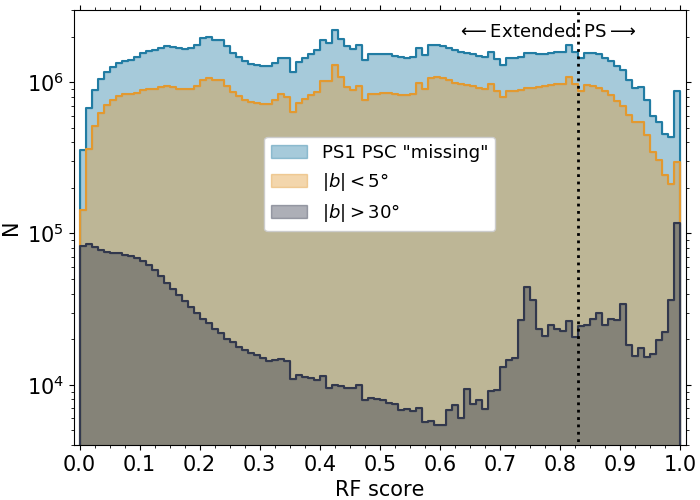

In [84]:
col_dict = {'mustard': "#E29930",
            'blue': "#217CA3",
            'asphalt': "#32384D"
           }

thresh = 0.83 #for nDet>2 sources

x_grid = np.repeat(np.linspace(0.0, 1, 101), 2)

ynorm = 1e6

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_grid, np.concatenate(([1e-10], np.repeat(all_cnts, 2), [1e-10])),
        color=col_dict['blue'])
ax.fill(x_grid, np.concatenate(([1e-10], np.repeat(all_cnts, 2), [1e-10])),
        alpha=0.4, color=col_dict['blue'], 
        label='PS1 PSC "missing"')

ax.plot(x_grid, np.concatenate(([1e-10], np.repeat(low_cnts, 2), [1e-10])), 
        color=col_dict['mustard'])
ax.fill(x_grid, np.concatenate(([1e-10], np.repeat(low_cnts, 2), [1e-10])),
        alpha=0.4, color=col_dict['mustard'],
        label=r"$|b| < 5\degree$")
ax.plot(x_grid, np.concatenate(([0], np.repeat(high_cnts, 2), [0])), 
        color=col_dict['asphalt'])
ax.fill(x_grid, np.concatenate(([1e-10], np.repeat(high_cnts, 2), [1e-10])),
        alpha=0.4, color=col_dict['asphalt'],
        label=r"$|b| > 30\degree$")

ax.set_yscale("log")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(4e3, 3e6)
ax.tick_params(which="both", top=True, right=True, labelsize=15)
xminor = MultipleLocator(0.05)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.set_xlabel("RF score", fontsize=15)
ax.set_ylabel("N", fontsize=15)

ax.vlines([thresh], 10, 1e9, 
          linestyles=":", 
          color='k', lw=2, zorder=11)
ax.text(thresh, .4e7, 'FoM threshold', 
        color='k', 
        rotation=90, ha="right", fontsize=14)
ax.text(thresh-0.001, 2e6, r'$\longleftarrow \mathrm{Extended}$ ', 
        color='k', 
        ha="right", fontsize=13)
ax.text(thresh, 2e6, r' $\mathrm{PS} \longrightarrow$', 
        color='k', 
        ha="left", fontsize=13)

ax.legend(loc=10, framealpha=1, bbox_to_anchor = (0.0,0.1,1,1), 
          bbox_transform=ax.transAxes, fontsize=13)

fig.subplots_adjust(left=0.105,right=0.98,top=0.98,bottom=0.11)
fig.savefig("../paperII/figures/PS1_PSC_update_hist.pdf")

In [81]:
print("There are {:d} sources classified in the ZTF-PS1 catalog".format(sum(all_cnts)))
print("There are {:d} stars using the FoM threshold".format(sum(all_cnts[np.where(np.linspace(0,0.99,100) >= thresh)])))
print("There are {:d} surefire stars (RF > 0.99)".format(all_cnts[-1]))
print("There are {:d} surefire galaxies (RF < 0.01)".format(all_cnts[0]))
print(" ")
print("At high (|b| > 30) latitudes:")
print("\t there are {:d} sources".format(sum(high_cnts)))
print("\t there are {:d} surefire galaxies (RF < 0.01)".format(high_cnts[0]))
print("\t there are {:d} stars using the FoM threshold".format(sum(high_cnts[np.where(np.linspace(0,0.99,100) >= thresh)])))
print("\t there are {:d} 50-50 stars (RF >= 0.5)".format(sum(high_cnts[np.where(np.linspace(0,0.99,100) >= 0.5)])))
print(" ")
print("At low (|b| < 5) latitudes:")
print("\t there are {:d} sources".format(sum(low_cnts)))
print("\t there are {:d} surefire stars (RF > 0.99)".format(low_cnts[-1]))
print("\t there are {:d} stars using the FoM threshold".format(sum(low_cnts[np.where(np.linspace(0,0.99,100) >= thresh)])))
print("\t there are {:d} 50-50 stars (RF >= 0.5)".format(sum(low_cnts[np.where(np.linspace(0,0.99,100) >= 0.5)])))

print("In the plane (|b| < 15):")
print("\t there are {:d} sources".format(sum(plane_cnts)))
print("\t there are {:d} surefire stars (RF > 0.99)".format(plane_cnts[-1]))
print("\t there are {:d} stars using the FoM threshold".format(sum(plane_cnts[np.where(np.linspace(0,0.99,100) >= thresh)])))
print("\t there are {:d} 50-50 stars (RF >= 0.5)".format(sum(plane_cnts[np.where(np.linspace(0,0.99,100) >= 0.5)])))

There are 144870754 sources classified in the ZTF-PS1 catalog
There are 17945494 stars using the FoM threshold
There are 869100 surefire stars (RF > 0.99)
There are 354537 surefire galaxies (RF < 0.01)
 
At high (|b| > 30) latitudes:
	 there are 2607123 sources
	 there are 82322 surefire galaxies (RF < 0.01)
	 there are 498163 stars using the FoM threshold
	 there are 953874 50-50 stars (RF >= 0.5)
 
At low (|b| < 5) latitudes:
	 there are 82991155 sources
	 there are 297608 surefire stars (RF > 0.99)
	 there are 10399264 stars using the FoM threshold
	 there are 41180519 50-50 stars (RF >= 0.5)
In the plane (|b| < 15):
	 there are 138428607 sources
	 there are 638900 surefire stars (RF > 0.99)
	 there are 16798358 stars using the FoM threshold
	 there are 66860963 50-50 stars (RF >= 0.5)


## Count sources that were missed in PS1 PSC v1

In [37]:
N_neg = 0 + 4331022 + 2643185 + 0 + 2583710 + 0 + 4118504 + 0 + 0 + 0 + 0 + 0 + 0 + 0 + 584621 + 1619083 + 4649772 + 1994380
print('There are {} stars below declination -30'.format(N_neg))

There are 22524277 stars below declination -30


### Loop over reason some stars are missing

#### Run the loop over all files

In [103]:
N_unique = 0
N_solo_not_det = 0
N_solo_force_det = 0
N_solo_pri0_force_det = 0
N_solo_pri0_no_force = 0
N_multi_pri2_force_det = 0
N_mutli_pri2_no_force = 0
N_multi_pri1_force_det = 0
N_mutli_pri1_no_force = 0
N_multi_pri0_force_det = 0
N_mutli_pri0_no_force = 0

nDet_hist = np.zeros(100)

missing_files = glob.glob('missing*fit')
for mf in missing_files:
    mf_tab = fits.getdata(mf)
    
    uni_counts = np.unique(mf_tab['objid'], return_index=True, return_inverse = True, return_counts=True)
    N_unique += len(uni_counts[0])
    print(N_unique)
    solo_idx = uni_counts[1][np.where(uni_counts[3] == 1)]
    multi_idx = uni_counts[1][np.where(uni_counts[3] > 1)]
    
    not_det = len(np.where((mf_tab['stackDet'][solo_idx] == 0) & 
                       (mf_tab['forceDet'][solo_idx] == 0))[0])
    force_det = len(np.where((mf_tab['stackDet'][solo_idx] == 0) & 
                           (mf_tab['forceDet'][solo_idx] == 1))[0])
    no_primary_det = len(np.where((mf_tab['stackDet'][solo_idx] == 1) & 
                           (mf_tab['forceDet'][solo_idx] == 1))[0])
    no_primary_no_force = len(np.where((mf_tab['stackDet'][solo_idx] == 1) & 
                           (mf_tab['forceDet'][solo_idx] == 0))[0])


    if not_det + force_det + no_primary_det + no_primary_no_force != len(solo_idx):
        print(mf, 'Ooops')
        break
    else:
        N_solo_not_det += not_det
        N_solo_force_det += force_det
        N_solo_pri0_force_det += no_primary_det
        N_solo_pri0_no_force += no_primary_no_force
    
    mf_df = pd.DataFrame(mf_tab.objid.byteswap().newbyteorder(), columns=['objid'])
    mf_df['nDetections'] = mf_tab.nDetections.astype(np.int32)
    mf_df['primaryDetection'] = mf_tab.primaryDetection
    mf_df['stackDet'] = mf_tab.stackDet
    mf_df['forceDet'] = mf_tab.forceDet
    
    tmp = mf_df.drop(mf_df.index[solo_idx])
    
    ha = tmp.groupby('objid')[['primaryDetection','forceDet']].sum()
    multi_pri2_force_det = len(ha.iloc[np.where((ha.primaryDetection >= 2) & (ha.forceDet > 1))].index.values.astype(int))
    mutli_pri2_no_force = len(ha.iloc[np.where((ha.primaryDetection >= 2) & (ha.forceDet < 1))].index.values.astype(int))
    multi_pri1_force_det = len(ha.iloc[np.where((ha.primaryDetection == 0) & (ha.forceDet > 1))].index.values.astype(int))
    mutli_pri1_no_force = len(ha.iloc[np.where((ha.primaryDetection == 0) & (ha.forceDet < 1))].index.values.astype(int))    
    multi_pri0_force_det = len(ha.iloc[np.where((ha.primaryDetection == 1) & (ha.forceDet >= 1))].index.values.astype(int))
    mutli_pri0_no_force = len(ha.iloc[np.where((ha.primaryDetection == 1) & (ha.forceDet == 0))].index.values.astype(int))
    
    if multi_pri2_force_det + mutli_pri2_no_force + multi_pri1_force_det + mutli_pri1_no_force + multi_pri0_force_det + mutli_pri0_no_force != len(multi_idx):
        print(mf, 'multi Ooops')
        break
    else:
        N_multi_pri2_force_det += multi_pri2_force_det
        N_mutli_pri2_no_force += mutli_pri2_no_force
        N_multi_pri1_force_det += multi_pri1_force_det
        N_mutli_pri1_no_force += mutli_pri1_no_force
        N_multi_pri0_force_det += multi_pri0_force_det
        N_mutli_pri0_no_force += mutli_pri0_no_force
    
    check_fd = mf_df.groupby('objid')[['forceDet']].sum()
    if len(np.where(check_fd.forceDet > 0)[0]) != (force_det + no_primary_det + 
      multi_pri2_force_det + multi_pri1_force_det + multi_pri0_force_det):
        print(mf, 'fDet Ooops')
        break
        
    meh = mf_df.groupby('objid')[['forceDet','nDetections']].mean()
    hist, _ = np.histogram(meh.nDetections.iloc[np.where(meh.forceDet == 0)], range=(3,103), bins=100)
    nDet_hist += hist
    
    del(mf_tab)
    del(mf_df)
    del(tmp)
    del(ha)
    gc.collect()

10942237
21881018
54707730
65061052
92416647
125243360
150604342
177959937
202732048
227444701
236767890
264123482
287185407
320005527
330947670
354184908
376884308
404239900


In [66]:
print(N_solo_force_det + N_solo_pri0_force_det + 
      N_multi_pri2_force_det + N_multi_pri1_force_det + N_multi_pri0_force_det)

144871049


In [75]:
print(N_multi_pri2_force_det + N_mutli_pri2_no_force)

5885633


In [116]:
print('For the 281434529 still not classified sources:')
print('\t{:9.0f} have nDetections = 3'.format(nDet_hist[0]))
print('\t{:9.0f} have nDetections <= 5'.format(sum(nDet_hist[0:3])))
print('\t{:9.0f} have nDetections <=10'.format(sum(nDet_hist[0:8])))

For the 281434529 still not classified sources:
	 96526463 have nDetections = 3
	156119760 have nDetections <= 5
	203865086 have nDetections <=10


### What's going on with the 3456 "missing" missing sources

In the output query to figure out why some sources are classified and others are not, there are some sources that did not return any results despite the use of "left joins". 

The short answer for why this happened (see below), is that the initial join to the `objectThin` table in PS1 was not a left join, and some sources (mostly those at declination < -30 deg) that were in DR1 and not in DR2. See the [PS1 DR2 caveats](https://outerspace.stsci.edu/display/PANSTARRS/PS1+DR2+caveats#PS1DR2caveats-Missingdata).

In [15]:
10942237-10938781

3456

In [3]:
mf_tab = fits.getdata(missing_files[1])
mf_df = pd.DataFrame(mf_tab.objid.byteswap().newbyteorder(), columns=['objid'])
mf_df

,objid
0,158192965655885550
1,158192965672797087
2,158192965698053392
3,158192965705828210
4,158192965765124423
...,...
12001452,215923229132547323
12001453,215942818324336804
12001454,215952945419937017
12001455,215963263580694778


In [4]:
all_tab = fits.getdata('PS1_star_galaxy.xhall.stars_20180814_1_adamamiller.fit')

In [15]:
all_df = pd.DataFrame(all_tab.strid.byteswap().newbyteorder(), columns=['strid'])
all_df.set_index(all_tab.strid.byteswap().newbyteorder(), inplace=True)
all_df.head()

,strid
158172965611696230,158172965611696230
158180265580420778,158180265580420778
158180265736439688,158180265736439688
158180265774019032,158180265774019032
158182965282128773,158182965282128773


In [16]:
all_df[~all_df.index.isin(np.unique(mf_tab.objid))]

,strid
196313437829205326,196313437829205326
196313441647357921,196313441647357921
196313442689476432,196313442689476432
196313443675458194,196313443675458194
196313444051274089,196313444051274089
...,...
199683443198693971,199683443198693971
199683444546785667,199683444546785667
199683445731448264,199683445731448264
199683447251668260,199683447251668260


### Answer

All of these sources are in a "hole" in the PS1 DR2 coverage. 



## Run the Counting Loop

In [2]:
def get_hist_counts(df):

    rf_arr = np.array(df.rf_score)

    coords = SkyCoord(np.array(df.raStack)*u.deg, np.array(df.decStack)*u.deg)

    all_cnts, _ = np.histogram(rf_arr, range=(0,1), bins=100)
    low_lat = np.where(np.abs(coords.galactic.b) < 15*u.deg)
    high_lat = np.where(np.abs(coords.galactic.b) > 50*u.deg)

    low_cnts, _ = np.histogram(rf_arr[low_lat], range=(0,1), bins=100)
    high_cnts, _ = np.histogram(rf_arr[high_lat], range=(0,1), bins=100)
    
    return all_cnts, low_cnts, high_cnts

In [3]:
file_list = glob.glob("/Users/adamamiller/Desktop/PS1_fits/hdf5/*h5")

In [4]:
all_cnts = np.zeros(100, dtype=np.int64)
low_cnts = np.zeros_like(all_cnts)
high_cnts = np.zeros_like(all_cnts)

for file in file_list:
    df = pd.read_hdf(file)
    all_tmp, low_tmp, high_tmp = get_hist_counts(df)
    all_cnts += all_tmp
    low_cnts += low_tmp
    high_cnts += high_tmp

## Make files for CasJobs upload

In [ ]:
cat_df = pd.read_csv('class_table.ascii.gz', delim_whitespace=True)
for i in range(17):
    start = i*8000000
    end = (i+1)*8000000
    cat_df.iloc[start:end].to_csv('update_{}.csv'.format(i), index=False)
cat_df.iloc[17*8000000:].to_csv('update_17.csv', index=False)